In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt

import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

from itertools import combinations
#%%capture  output
import itertools
from tqdm import tqdm


import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
from tensorflow import keras

from scipy import stats

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.Series(x.indices)
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]

def reclassify(s):
    if s is None:
        return None
    #spt_unc=s.spectral_type[1
    #rngs=[[1.17,1.35],[1.45,1.67]]
    rngs=[[1.15, 1.65]]
    spt, spt_e= splat.classifyByStandard(s.splat_spectrum, fitrange=[[1.15, 1.65]], 
                                         sptrange=['M0','Y1'], average=True)
    #s.classify_by_standard(comprange=rngs)
    #print(wisps.make_spt_number(spt))
    #spt, spt_e=wisps.classify_by_templates(s, comprange=rngs)
    s.spectral_type=(np.round(wisps.make_spt_number(spt)), spt_e)
    s.calculate_distance(use_spt_unc=True, use_index_type=False)
    
    return s

In [3]:
#read in the data
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.hdf', key='all')
spectra= [reclassify(x) for x in cands0.spectra]
cands0['spectra']=spectra
cands=cands0.spectra.apply(get_indices)
cands['spectra']=cands0.spectra
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)
canddf=cands[~cands.spectra.isna()].reset_index(drop=True)
canddf['spt']=canddf.spectra.apply(lambda x: x.spectral_type[0])
canddf['spt_er']=canddf.spectra.apply(lambda x: x.spectral_type[1])
canddf['distance']=canddf.spectra.apply(lambda x: x.distance['val'].value)
canddf['distance_er']=canddf.spectra.apply(lambda x: x.distance['er'].value)
canddf['coord']=canddf.spectra.apply(lambda x:x.coords)
canddf['designation']=canddf.spectra.apply(lambda x: x.designation)
#canddf['index_type_er']=canddf.spectra.apply(lambda x: x.index_type[1])
canddfj=canddf.join(canddf.spectra.apply(lambda x: pd.Series(x.mags)))
canddff=canddfj.join(canddf.spectra.apply(lambda x: pd.Series(x.snr)))
canddff['spectra']=canddf.spectra

canddff=canddff.drop_duplicates('designation')
#noisy and re-checked objects
exclude=['J01253527-0001383', 'J20220361-3113264', 
         'J05300520-0723374', 'J05315184-0723016',
         'J14313999+2447186', 'J15343866+5014150', 'J10044909+5258293',
         'J14193494+5256146', 'J15474619+2057475']
ucds=wisps.Annotator.reformat_table((canddff[(canddff.spt>=17) & \
                                             (~(canddff.designation.str.upper().isin(exclude))) \
]).reset_index(drop=True)).sort_values(by='spt')
#remove some objects by name
ucds=(ucds[~ ucds.grism_id.isin(['par199-00124'])]).reset_index(drop=True).sort_values(by='spt')

In [4]:
len(cands)

430

In [5]:
len(ucds), len(ucds[ucds.spt.between(17, 20)]), len(ucds[ucds.spt.between(20, 30)]), len(ucds[ucds.spt.between(30, 40)])

(158, 124, 29, 10)

In [6]:
sp=ucds.spectra.iloc[1].splat_spectrum

In [7]:
ucds.spectra.iloc[1].spectral_type

(17.0, 1.7641880103419099)

In [8]:
sp.trim([1.1, 1.7])

In [9]:
 splat.classifyByStandard?

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


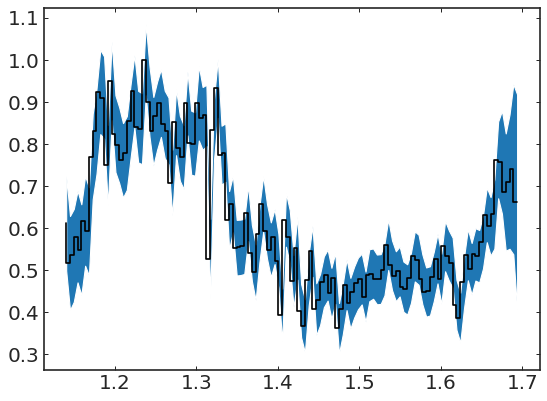

In [10]:
fig, ax=plt.subplots()
ax.step(sp.wave, sp.flux, c='k')
ax.fill_between(sp.wave, sp.flux-sp.noise, sp.flux+sp.noise)

In [11]:
#ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')
#selection objects 
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/deep_model_september23.h5')
#neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/conv_model_withspt_snr_september17.h5')

In [12]:
import wisps.data_analysis.selection_criteria as sel_crt
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
slc_crts=sel_crt.crts_from_file()

In [13]:
big=wisps.get_big_file()

In [14]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def select_by_indices(df, idx, spt_range):
    print(spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    _, bools= bx._select(np.array([df[idx.xkey].values, df[idx.ykey].values]))
    return bools
        

def apply_scale(x):
    ##remove nans 
    ##this is the same scaling used 
    ## same scaling used for 
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y


def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    #min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt', 'f_test', 'x']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #make predictions
    probs=rf.predict_proba(pred_df[features].values)
    labels=np.logical_or.reduce((
                                 probs[:,2] > .8, \
                                 probs[:,3] >.8 ,\
                                 probs[:,4] >0.8))
    
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
    #labels=rf.predict(pred_df[features].values)
 
    return {'probs': probs, 'labels': labels}



def select_by_neuralnet(df):
    #define features (start with indices alone)
    #apply logs to problematic features the same way I did on my classification
    features=rfdict['feats']
    
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #probs= neural_network.predict(  pred_df[features].values)
    #need to reshape
    #probs=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    
    #my cuts
    #labels=np.logical_or.reduce((probs[:, 2] > .7, probs[:,3] >.5 , probs[:,4] >0.5))
    #labels=probs[:,0] <0.5
    #labels=neural_network.predict_classes(  pred_df[features].values.reshape(-1, len(features), 1))
    #labels=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    probs= neural_network(  pred_df[features].values, training=False)
    labels=np.logical_or.reduce((
                                probs[:, 2] > .8, \
                                 probs[:,3] >.8 ,\
                                 probs[:,4] >0.8))
    
    #labels=np.logical_or.reduce([probs[:, 1]>0.9, labels ])
    #labels=neural_network.predict_classes(  pred_df[features].values)
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
 
    return {'probs': probs, 'labels': labels}



In [15]:
ucds['x']=ucds.spectra.apply(lambda x: x.spex_chi/x.line_chi)
ucds['line_chi']=ucds.spectra.apply(lambda x: x.line_chi)
ucds['spex_chi']=ucds.spectra.apply(lambda x: x.spex_chi)
ucds['f_test']=ucds.spectra.apply(lambda x: x.f_test)

In [16]:
#ucds.columns

In [17]:
#ucds['x']=

In [18]:
ls=select_by_neuralnet(ucds)
rf_ls= select_by_random_forest(ucds)

In [19]:
max_probs=np.nanmax(ls['probs'], axis=1)
argma_probs=np.argmax(ls['probs'], axis=1)

In [20]:
#ls

In [21]:
#ucds.columns

In [22]:
lp=select_by_neuralnet(big)

In [23]:
pred_max_probs=np.nanmax(lp['probs'], axis=1)
pred_argma_probs=np.argmax(lp['probs'], axis=1)

In [24]:
len(big[big.grism_id.str.lower().isin(ucds.grism_id.str.lower())])

158

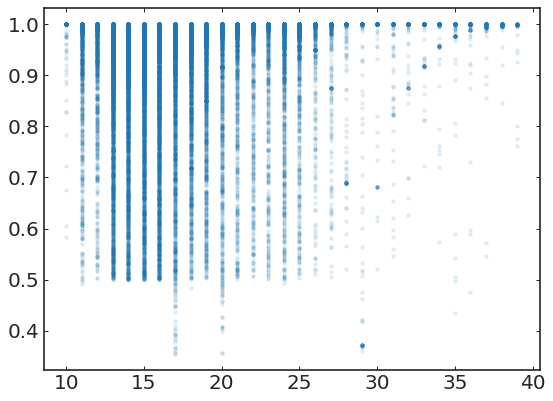

In [25]:
plt.plot(big.spt.values, pred_max_probs, '.', alpha=0.1)
#plt.plot(ucds.spt.values, max_probs, '.')

[Text(0, 0.5, 'Class'),
 Text(0.5, 0, 'Max Probability'),
 [Text(0, 0.0, 'Gal'),
  Text(0, 1.0, 'Early M'),
  Text(0, 2.0, 'M7-L0'),
  Text(0, 3.0, 'L'),
  Text(0, 4.0, 'T')]]

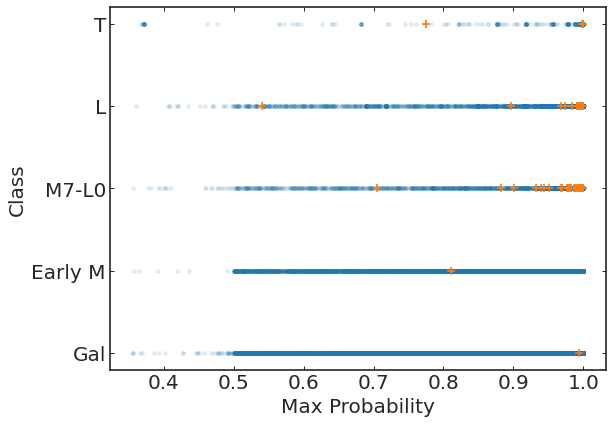

In [26]:
fig, ax=plt.subplots()
ax.scatter(pred_max_probs, pred_argma_probs, s=10., alpha=0.1, label='Selected')
ax.scatter(max_probs, argma_probs, s=50., marker='+', label='Real')

ax.set(ylabel='Class', xlabel='Max Probability',
       yticks=[0., 1., 2., 3., 4.], yticklabels=['Gal', 'Early M', 'M7-L0', 'L', 'T'])


In [27]:
ucds[argma_probs==0.][['snr1', 'spt',  'spt_er', 'grism_id', 'distance']]

,snr1,spt,spt_er,grism_id,distance
92,7.22447,18.0,2.541483,goodss-06-g141_11322,1779.214703


In [28]:
ucds[argma_probs==1.][['snr1', 'spt', 'spt_er', 'grism_id', 'distance']]

,snr1,spt,spt_er,grism_id,distance
8,31.77125,17.0,0.721058,par398-00028,900.037012


In [29]:
#

[Text(0.5, 0, 'Class'),
 Text(0, 0.5, 'Number'),
 [Text(0.0, 0, 'Gal'),
  Text(1.0, 0, 'Early M'),
  Text(2.0, 0, 'M7-L0'),
  Text(3.0, 0, 'L'),
  Text(4.0, 0, 'T')]]

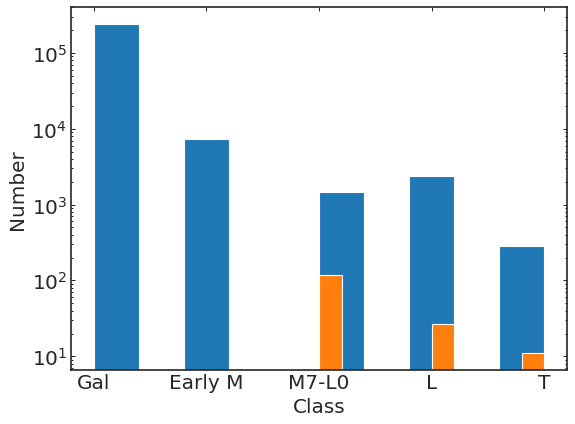

In [30]:
fig, ax=plt.subplots()
h=plt.hist(pred_argma_probs, log=True,   label='All predictions')
h=plt.hist(argma_probs[(argma_probs >=2. )], \
           label='SNR cut')

ax.set(xlabel='Class', ylabel='Number',
       xticks=[0., 1., 2., 3., 4.], xticklabels=['Gal', 'Early M', 'M7-L0', 'L', 'T'])


In [31]:
ucds.grism_id=ucds.grism_id.str.lower()
big.grism_id=big.grism_id.str.lower()

In [32]:

#add labels for index selection
ucds['selected_by_rf']=rf_ls['labels']
ucds['selected_by_nn']=ls['labels']

In [33]:
indices_to_use

[('CH_4/J-Cont H_2O-1+H_2O-2/J-Cont', 'M7-L0'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L0-L5'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/J-Cont', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('CH_4/H-Cont H_2O-1+CH_4/J-Cont', 'subdwarfs')]

In [34]:
selection_table={}
selection_table['rf']={}
selection_table['nn']={}
selection_table['indices']={}

In [35]:


#rfselection=pd.read_csv(wisps.OUTPUT_FILES+'/selected_by_rf.csv')
#nnres=pd.read_pickle(wisps.OUTPUT_FILES+'/deep_neural_net_classifier_results.pkl')

#rfselection.shape

#nnsel= pd.concat(nnres['selected'])

nnselection =pd.DataFrame()
rfselection=pd.DataFrame()

#nnselection['grism_id']=ucds.grism_id[ls['labels']]
#rfselection['grism_id']= ucds.grism_id[rf_ls['labels']]
#nnselection=nnselection.drop_duplicates('grism_id')



labelled=wisps.Annotator.group_by_spt(ucds, spt_label='spt', assign_number=False)

for idxk, k in indices_to_use:
    idx=slc_crts[idxk]
    labelled['selected_by_{}'.format(k)]= select_by_indices(labelled, idx, k)

labelled['index_label']=np.logical_or.reduce([labelled['selected_by_{}'.format(x)].values 
                                              for x in  np.vstack(indices_to_use)[:,1]])

for g in labelled.groupby('spt_range'):
    df0=g[1]
    print ('{}'.format(g[0]))
    print ('selected by rf {}'.format(len(df0[df0.selected_by_rf])))
    print ('selected by NN {}'.format(len(df0[df0.selected_by_nn])))
    print ('selected by indices {}'.format(len(df0[df0.index_label])))
    selection_table['rf'][g[0]]=len(df0[df0.selected_by_rf])
    selection_table['nn'][g[0]]=len(df0[df0.selected_by_nn])
    selection_table['indices'][g[0]]=len(df0[df0.index_label])
    #print ('selected by rf or indices {}'.format(len(df0[np.logical_or(df0.index_label,df0.selected_by_rf) ])))
    #print ('selected by NOT rf and indices {}'.format(len(df0[np.logical_and(df0.index_label,~df0.selected_by_rf) ])))
    #print ('selected by rf and NOT indices {}'.format(len(df0[np.logical_and(~df0.index_label,df0.selected_by_rf) ])))
    #print ('selected by NN or indices {}'.format(len(df0[np.logical_or(df0.index_label,df0.selected_by_nn) ])))
    #print ('selected by NOT NN and indices {}'.format(len(df0[np.logical_and(df0.index_label,~df0.selected_by_nn) ])))
    #print ('selected by NN and NOT indices {}'.format(len(df0[np.logical_and(~df0.index_label,df0.selected_by_nn) ])))
    #print ('---------------------------------------------------------------- ')

M7-L0
L0-L5
L5-T0
T0-T5
T5-T9
Y dwarfs
subdwarfs
L0-L5
selected by rf 13
selected by NN 18
selected by indices 18
L5-T0
selected by rf 5
selected by NN 5
selected by indices 6
M7-L0
selected by rf 104
selected by NN 121
selected by indices 122
T0-T5
selected by rf 6
selected by NN 6
selected by indices 5
T5-T9
selected by rf 3
selected by NN 3
selected by indices 3


In [36]:
pd.DataFrame.from_records(selection_table).T[['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9']]

,M7-L0,L0-L5,L5-T0,T0-T5,T5-T9
indices,122,18,6,5,3
nn,121,18,5,6,3
rf,104,13,5,6,3


In [37]:
ucds=labelled

In [38]:
def ucd_selection_method(ro):
    select=''
    if ro.index_label:
        select +="Indices, "
    if ro.selected_by_nn:
        select +="DNN, "
    if ro.selected_by_nn:
        select +="RF "
    if select.endswith(', '):
        select=select.replace(',', '')
    return select

In [39]:
#make that colormap
ucds['selection']=ucds.apply(ucd_selection_method, axis=1).values

In [40]:
bools=(ucds['selection']=='').values

In [41]:
np.round(labelled.snr1.min())

3.0

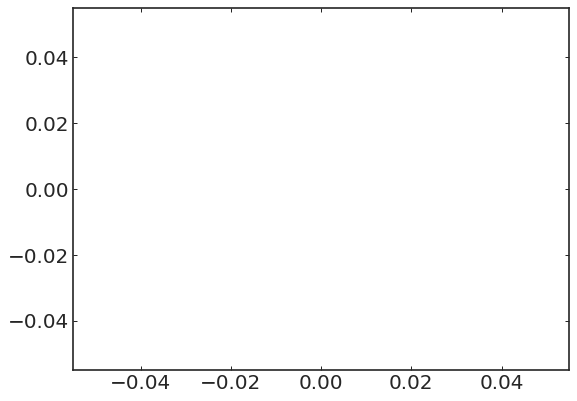

In [42]:
#h=plt.plot(ls['probs'][:,0], linestyle='--')
h=plt.plot(ls['probs'][bools][:,1], '+')
#h= plt.plot(rf_ls['probs'][:,0], linestyle='--')
h= plt.plot(rf_ls['probs'][bools][:,1], '+')

In [43]:
#plt.hist(np.array(ls['probs'])[:,0], log=True)

In [44]:
#probs=lp['probs']
#lab

In [45]:
#labels=np.logical_or.reduce((
#                                probs[:, 2] > .8, \
#                                 probs[:,3] >.95 ,\
#                                 probs[:,4] >0.8))
    
#labelsx=np.logical_and.reduce([ probs[:, 0] < .1, labels ])

In [46]:
#(labelsx==labels).all()

In [47]:
#plt.hist(np.array(probs[:, 0]), log=True)

In [48]:
#plt.plot(labels.astype(int), '.')
#plt.plot(labelsx.astype(int), '.')
#plt.plot(labels.astype(int), '.')

In [49]:
missed=ucds[ucds.grism_id.str.upper().isin(['PAR322-00030',  'PAR50-00017',  \
                                     'PAR170-00053', 'PAR293-00059',  \
                                     'PAR104-00019'])]

In [50]:
bs=idx.shapes

In [51]:
bx=[x for x in bs if x.shape_name=='M7-L0'][0]

In [52]:
ucds=wisps.tools.Annotator.group_by_spt(ucds, spt_label='spt')

In [53]:
len(ls['probs'][:,2][(ucds['spt_range']=='M7-L0').values])

124

In [54]:
#probability of being 
new_bools=(rf_ls['probs'][:,2]>0.1) & (rf_ls['probs'][:,3]>0.5)
missed_bools=(ucds.selection=='').values
#new_bools=(rf_ls['probs'][:,3]<0.5) & (rf_ls['probs'][:,3]>0.5)

In [55]:
ls['probs'][:,0][missed_bools]

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [56]:
rf_ls['probs'][:,0][missed_bools]

array([], dtype=float64)

In [57]:
ls['probs'][:,2][missed_bools]

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [58]:
ls['probs'][:,2][missed_bools]

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [59]:
#ucds[['spt', 'selection']][ np.array(ls['probs'][:,0]<0.5) & np.array(ls['probs'][:,1]>0.3)]

In [60]:
#

In [61]:
def plot_spectrum(s):
    s.plot(save=True, filename='/users/caganze/desktop/'+s.filename+'.pdf')
    

In [62]:
#rf_ls['labels']

In [63]:
#plt.plot(rf_ls['labels'], rf_ls['probs'][:,2], '.')

In [64]:
#ucds[missed_bools].spectra.apply(plot_spectrum)

In [65]:
indices_to_use

[('CH_4/J-Cont H_2O-1+H_2O-2/J-Cont', 'M7-L0'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L0-L5'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/J-Cont', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('CH_4/H-Cont H_2O-1+CH_4/J-Cont', 'subdwarfs')]

In [66]:
idx=slc_crts['CH_4/J-Cont H_2O-1+H_2O-2/J-Cont']
idx1=slc_crts['H_2O-1/J-Cont H_2O-2+CH_4/H-Cont']

In [67]:
bs=idx.shapes
bs1=idx1.shapes

In [68]:
bx=[x for x in bs if x.shape_name=='M7-L0'][0]
bx1=[x for x in bs1 if x.shape_name=='L0-L5'][0]

In [69]:
ucds[missed_bools].spt

Series([], Name: spt, dtype: float64)

fig,(ax, ax1)=plt.subplots(ncols=2, figsize=(12, 6))
c=ax.scatter(ucds['CH_4/J-Cont'][~missed_bools], ucds['H_2O-1+H_2O-2/J-Cont'][~missed_bools], s=1)
c=ax.scatter(ucds['CH_4/J-Cont'][missed_bools].iloc[0], ucds['H_2O-1+H_2O-2/J-Cont'][missed_bools].iloc[0],
            marker='*', s=200)
c=ax.scatter(ucds['CH_4/J-Cont'][missed_bools].iloc[1], ucds['H_2O-1+H_2O-2/J-Cont'][missed_bools].iloc[1],
            marker='*', s=200)


c=ax1.scatter(ucds['H_2O-1/J-Cont'][~missed_bools], ucds['H_2O-2+CH_4/H-Cont'][~missed_bools], s=1)
c=ax1.scatter(ucds['H_2O-1/J-Cont'][missed_bools].iloc[-1], ucds['H_2O-2+CH_4/H-Cont'][missed_bools].iloc[-1],
               marker='*', s=200)

bx1.plot(ax=ax1)
bx.plot(ax=ax)


ax.set(title='M7-L0 Selection')
ax1.set(title='L0-L5 Selection')

In [70]:
ucds.spectra.apply(lambda x: x.distance)

0      {'val': 1411.0456362009131 pc, 'er': [521.3681...
35     {'val': 1142.3657770771636 pc, 'er': [3111.600...
36     {'val': 987.4358962486361 pc, 'er': [7937.9604...
37     {'val': 1916.081852044526 pc, 'er': [18717321....
38     {'val': 1188.6964222651916 pc, 'er': [1885.146...
                             ...                        
153    {'val': 331.8524011877218 pc, 'er': [106.95263...
154    {'val': 710.4282853783673 pc, 'er': [183.55389...
155    {'val': 169.98163861341595 pc, 'er': [65.67899...
156    {'val': 147.74540663689157 pc, 'er': [80.00695...
157    {'val': 83.3429593097496 pc, 'er': [43.3115376...
Name: spectra, Length: 158, dtype: object

In [71]:
def formatted_distance(x):
    d= str(int(round(np.nan_to_num(x.distance['val'].value), 0)))
    der=[str(int(abs(round(np.nan_to_num(x.distance['er'].value[0]), 0)))),\
            str(int(abs(round(np.nan_to_num(x.distance['er'].value[0]), 0))))]
         
    if abs(x.distance['er'].value[0])/x.distance['val'].value >0.9:
        return "$\\approx$"+d
    else:
        #return r'$'+d+'\substack{+'+der[0]+'\\\ -'+der[-1]+'}$'
        return d+'$^{+'+der[0]+'}'+'_{-'+der[1]+'}$'

In [72]:
fdf=ucds[~missed_bools]

In [73]:
latc_df=pd.DataFrame()
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper().replace('_', '-'))
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(round(x.spectral_type[1], 1)))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
#latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
#latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
#latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(formatted_distance)
latc_df['Selected By']= fdf['selection']
latc_df=latc_df.replace('nan$\\pm$nan', '\nodata')

In [74]:
col_list=['designation','grism id', 'f110', 'f140', 'f160', \
          'snrj', 'spt', 'distance','Selected By']

In [75]:
latc_df[col_list].to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, escape=False, na_rep=' ')

In [76]:
latc_df[col_list].to_latex('/users/caganze/desktop/candidates.tex',
             header=True, index=False, escape=False, na_rep=' ')

In [77]:
latc_df[['spt', 'grism id', 'snrj']][latc_df['Selected By']==''].values

array([], shape=(0, 3), dtype=object)

In [78]:
md_warf_boo=latc_df.spt.apply(lambda x: splat.typeToNum(x.split('$\\pm$')[0]))<20

In [79]:
mdrf_all=latc_df[['designation', 'spt', 'f110', 'f140', 'f140', 'snrj']][md_warf_boo].reset_index(drop=True)

In [80]:
mdrf_all['designation']=mdrf_all.designation.apply(lambda x: splat.designationToShortName(x))

In [81]:
mdrf_all.replace('\nodata', '').to_csv('/users/caganze/desktop/wfc3_latemdwarfs.csv')

In [82]:
np.nanmedian(latc_df.spt.apply(lambda x:float(x.split('$\\pm$')[-1])))

1.45

In [83]:
lp=select_by_neuralnet(big)

In [84]:
rf_lp=select_by_random_forest(big)

In [97]:
big[(big.snr1>=3) & lp['labels']].grism_id.to_csv(wisps.OUTPUT_FILES+'/selected_bynn.csv')

In [100]:
big[(big.snr1>=3) & rf_lp['labels']].grism_id.to_csv(wisps.OUTPUT_FILES+'/selected_byrf.csv')

In [99]:
len(big[(big.snr1>=3) & rf_lp['labels']]), len(big[(big.snr1>=3) & lp['labels']])

(250, 1323)

In [88]:
rf_ls['probs'][:,3][([ucds.selection==''])[0].values]

array([], dtype=float64)

In [89]:
ls['probs'][:,3][~ls['labels']]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.0453845e-06, 7.5132959e-08, 4.5048306e-03, 5.4010236e-01,
       2.2444198e-01], dtype=float32)>

In [90]:
#plot and save new data
ucds.to_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')

In [91]:
latc_df[latc_df.Shortname=='WISP J09505808+3544046']

,Shortname,designation,grism id,snrj,spt,ra,dec,f110,f140,f160,distance,Selected By
101,WISP J09505808+3544046,J09505808+3544046,PAR192-00026,18,M8.0$\pm$0.7,147.742004,35.7346,\nodata,21.467$\pm$0.01,\nodata,700$^{+169}_{-171}$,"Indices, DNN, RF"


In [92]:
latc_df[latc_df.Shortname=='WISP J15001904+4127259']

,Shortname,designation,grism id,snrj,spt,ra,dec,f110,f140,f160,distance,Selected By
97,WISP J15001904+4127259,J15001904+4127259,PAR391-00011,33,M8.0$\pm$1.0,225.07933,41.4572,20.929$\pm$0.002,\nodata,20.719$\pm$0.005,687$^{+177}_{-186}$,"Indices, DNN, RF"


### 